These notes on MCMC fitting closely follow [Imad Pasha's MCMC Guide](https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html). 

Markov-Chain Monte Carlo (MCMC) methods are useful for exploring parameter spaces, and can be used to fit models to data. In essence, it is a sampler -- it shouldn't be used to optimize model parameters to describe some data. The strenght of MCMC lies in its ability to sample from a posterior distribution around those optimal values to model the data. For this, we compare models generated by some parameters against data, trying to sample from the set of parameters that produce well-fiting models. We must impose priors on our parameters, setting (sometimes wide) ranges for their values. 

Omitting some stochastic elements for simplicity, the general process is as follows: 
1. Create a function that, given a set of input parameters, outputs a model.
2. Create a ensemble of "walkers" defined by vector $\theta$, containing the set of parameters used by the model-generating function. 
3. Consider the parameter space, a multidimensional "grid" of possible values $\theta$ bounded by prior ranges.
4. Walkers explore the parameter space by "stepping" to a new value of $\theta$, generating a new model using those parameter values. It compares the model to the given data, traditionally through a $\chi^2$ check for "likeness".
5. Compare the ratio of the the likeness of the new and old models. Generally speaking, if the new location in the parameter spaces produces a better match (is more likely), move to the new location and repeat. Otherwise, return to the old previous and try a new direction. 
6. Gradually, walkers navigate parameter space to regions of high likeness between generated models and data.
   
Note that in practice, we sample a local distribution (traditionally a Gaussian centered around $\theta$, with variance contfirst_rolling_avg the step-size hyperparameter) to randomly select each step direction. Furthermore, when deciding whether to accept the new $\theta$, the ratio of likelihoods is compared a random number between 0 and 1. Walkers store every the $\theta$ vector and corresponding likelihood at each iteration, creating a posterior distribution (chain). By letting these random walks continue for sufficient cycles, they will converge to posterior distribution ("spread") that reasonably represents our data. Also note that this process doesn't search for best-fit -- we aren't looking for the optimal $\theta$. Rather, the spread of models in the resulting posterior chain helps us constrain parameters in the model. This is shown more clearly through example. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

Using a dataset of measurements from ice-core samples over several million years, we will focus on temperature deviaton from average ($\Delta T$). 

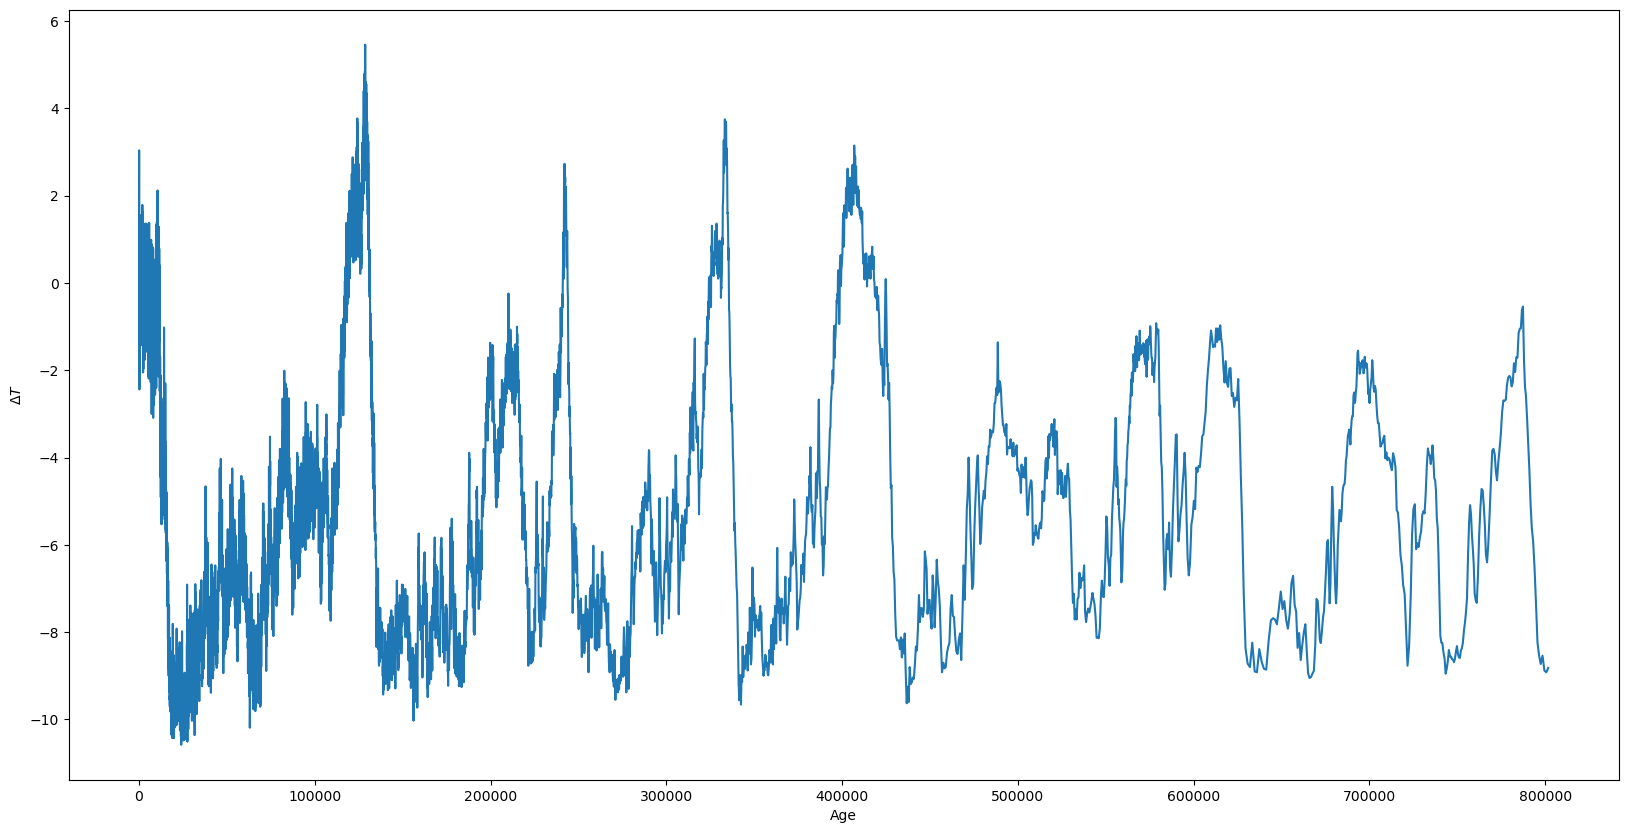

In [3]:
raw_ice_data = np.loadtxt("/Users/kahaan/Desktop/Torch/datasets/ice_core_data.txt")
ice_data = np.transpose(raw_ice_data)
age = ice_data[2]
T = ice_data[4]
plt.plot(age, T)
plt.xlabel("Age")
plt.ylabel("$\Delta T$")
plt.show()

According to a [Wikipedia article](https://en.wikipedia.org/wiki/Milankovitch_cycles), these fluctations are driven by three effects, each with their own period (26,000 years, 41,000 years, and 100,000 years). So, we will approximate the above flucations as the sum of three sinusoids (and therefore 7 parameters): 
$$
\Delta T = T_0 + a_1 \sin \left( \frac{2 \pi t}{p_1} \right) + a_2 \sin \left( \frac{2 \pi t}{p_2} \right) + a_3 \sin \left( \frac{2 \pi t}{p_3} \right)
$$

In [48]:
def model(theta, age=age):
    """
    Takes a list representing theta vector, returning model evaluated for that set of parameters.
    Age is set to age array defined above. 
    """
    a1, a2, a3, p1, p2, p3, T0 = theta
    return T0 + a1*np.sin(2*np.pi*age/p1) + a2*np.sin(2*np.pi*age/p2) + a3*np.sin(2*np.pi*age/p3)

def lnlike(theta, x, y, yerr):
    """
    Measures how good of a fit the model is for a given set of parameters. 
    Similar to chi-squared test, weighted by error.
    """
    return -0.5 * np.sum(((y - model(theta, x)) / yerr) ** 2)

def lnprior(theta):
    """
    Checks that all variables values for current theta are within bounds set by prior. 
    Output is arbitrary (T/F), but 0.0 and np.inf are used by emcee. 
    """
    a1, a2, a3, p1, p2, p3, T0 = theta
    if (0.0 < a1 < 5.0 and 0.0 < a2 < 5.0 and 0.0 < a3 < 5.0) and \
    (10000 < p1 < 200000 and 10000 < p2 < 200000 and 10000 < p3 < 200000) and \
    (-10.0 < T0 < 0):
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    """
    If priors are good, measure likeness. Note that lp is 0 for valid priors. 
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Terr = 0.05*np.mean(T)      # Assume 5% error for yerr array 
data = (age, T, Terr)       # Create tuples to feed into functions
nwalkers = 240              
niter = 1024  
initial = np.array([1.0, 1.0, 1.0, 26000, 41000,100000,-4.5])                               # Initial guess
p0 = [np.array(initial) + 1e-7 * np.random.randn(len(initial)) for i in range(nwalkers)]    # Step through grid

def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Running burn-in")                # " Warm up" period
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Running production")             # Good samples
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler, pos, prob, state        # Sampler contains all walker chains 

In [49]:
sampler, pos, prob, state = main(p0,nwalkers,niter,len(initial),lnprob,data)

Running burn-in
Running production


In [52]:
def plotter(sampler, age=age, T=T):
    plt.ion()
    plt.plot(age, T, label = "$\Delta T$")
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:    # Plot 100 samples
        plt.plot(age, model(theta, age), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Time (years)')
    plt.ylabel('$\Delta$ T (degrees)')
    plt.legend()
    plt.show()

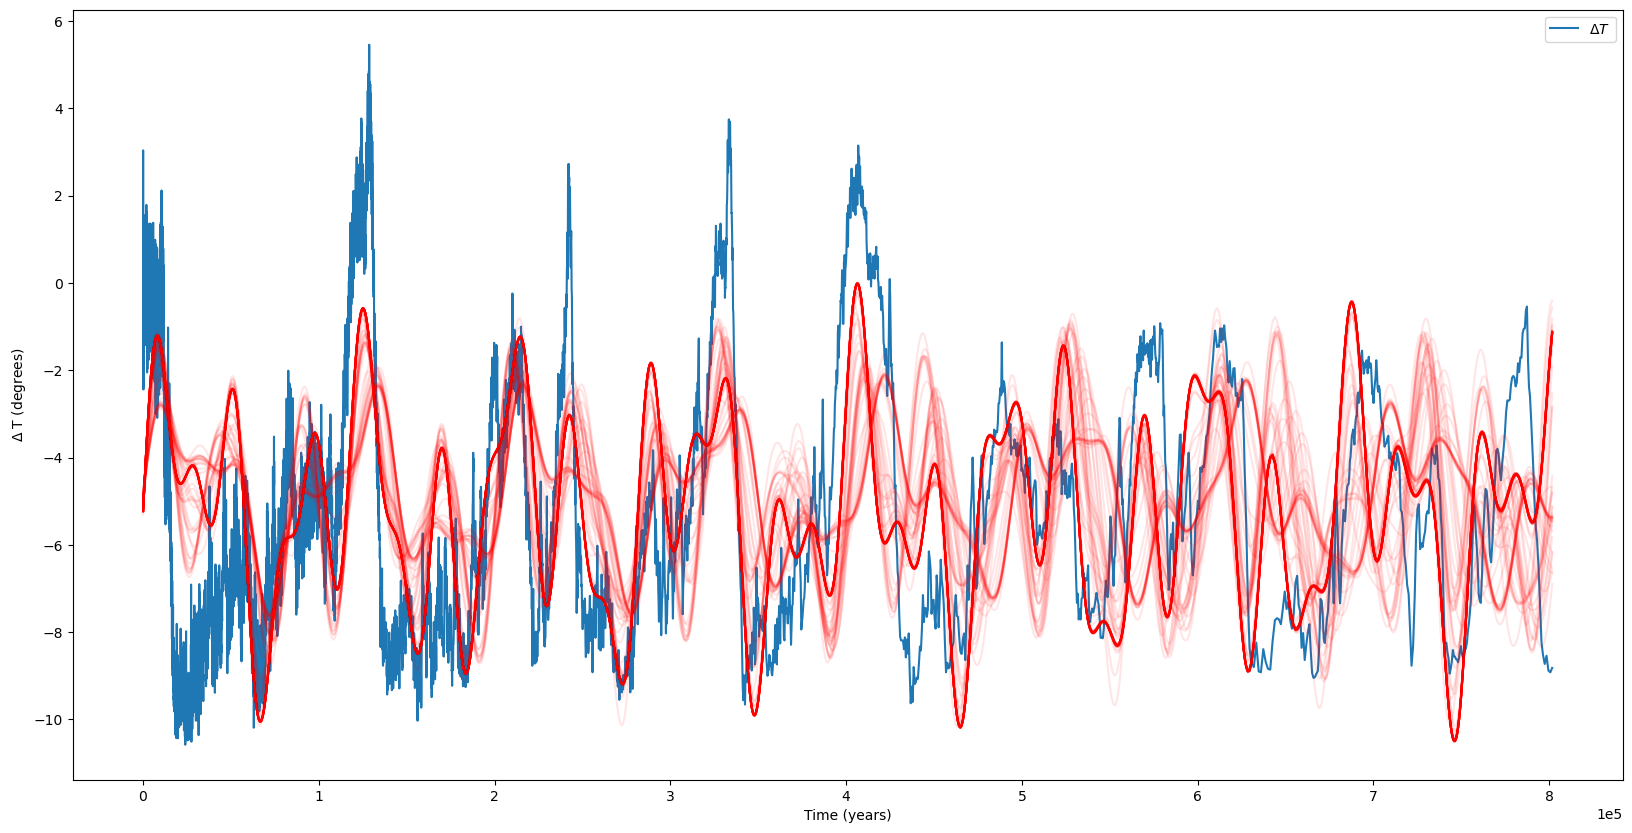

In [53]:
plotter(sampler)

We see that the 100 randomly selected samples have noticable overlap. Looking at the best fit: 

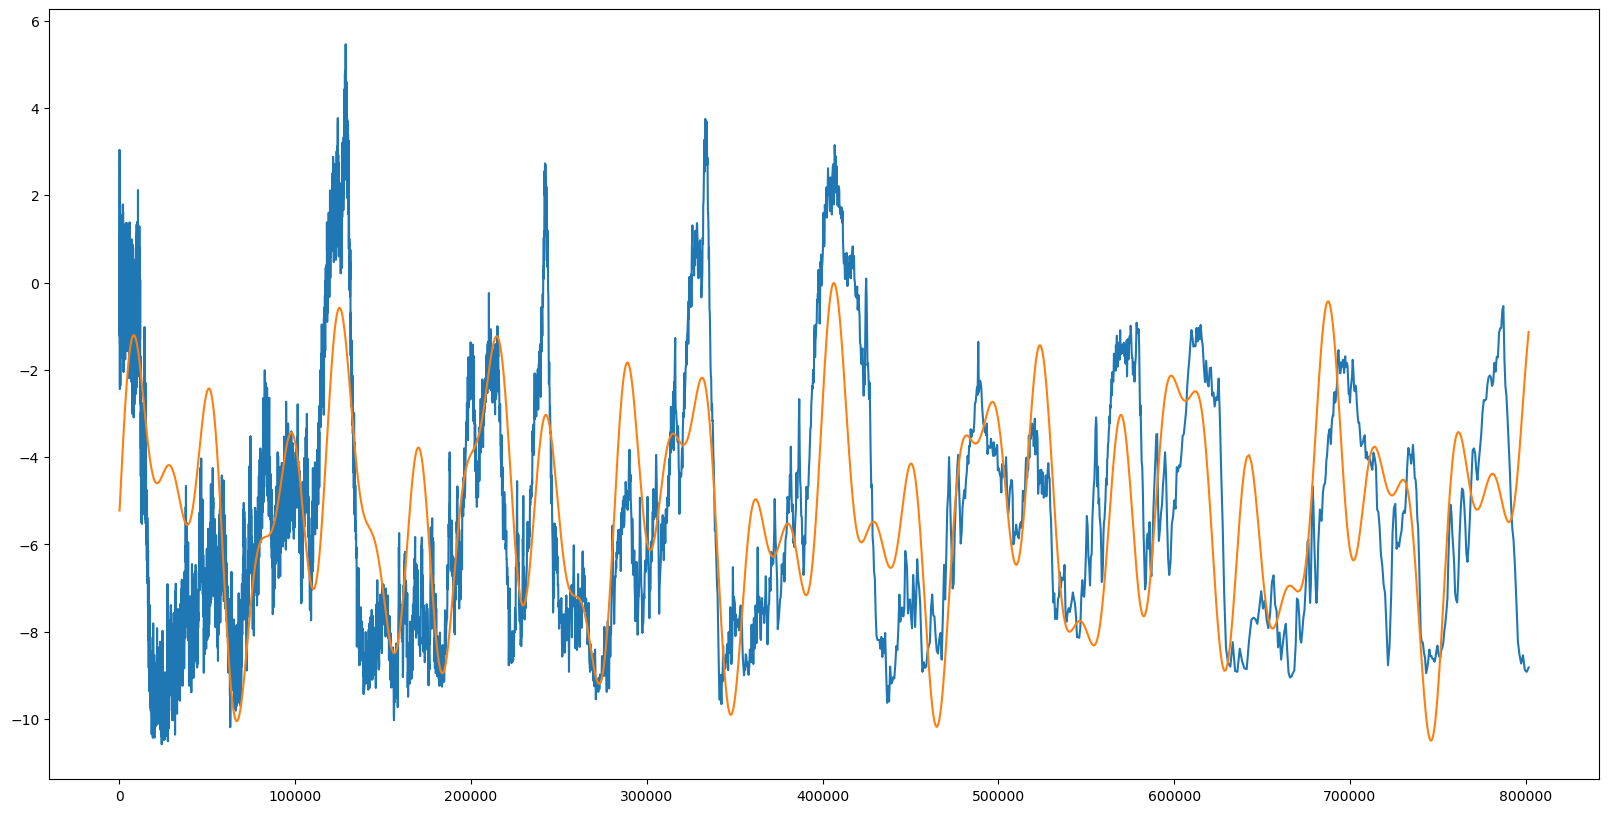

In [54]:
samples = sampler.flatchain                                     # Out of all the samples...
theta_max = samples[np.argmax(sampler.flatlnprobability)]       # find the highest likeness score...
best_fit = model(theta_max)                                     # and use those theta values
plt.plot(age,T,label='$\Delta T$')
plt.plot(age,best_fit,label='Highest Likelihood Model')
plt.show()

We can check the 1D and 2D spreads of parameters, as well as some uncertainties: 

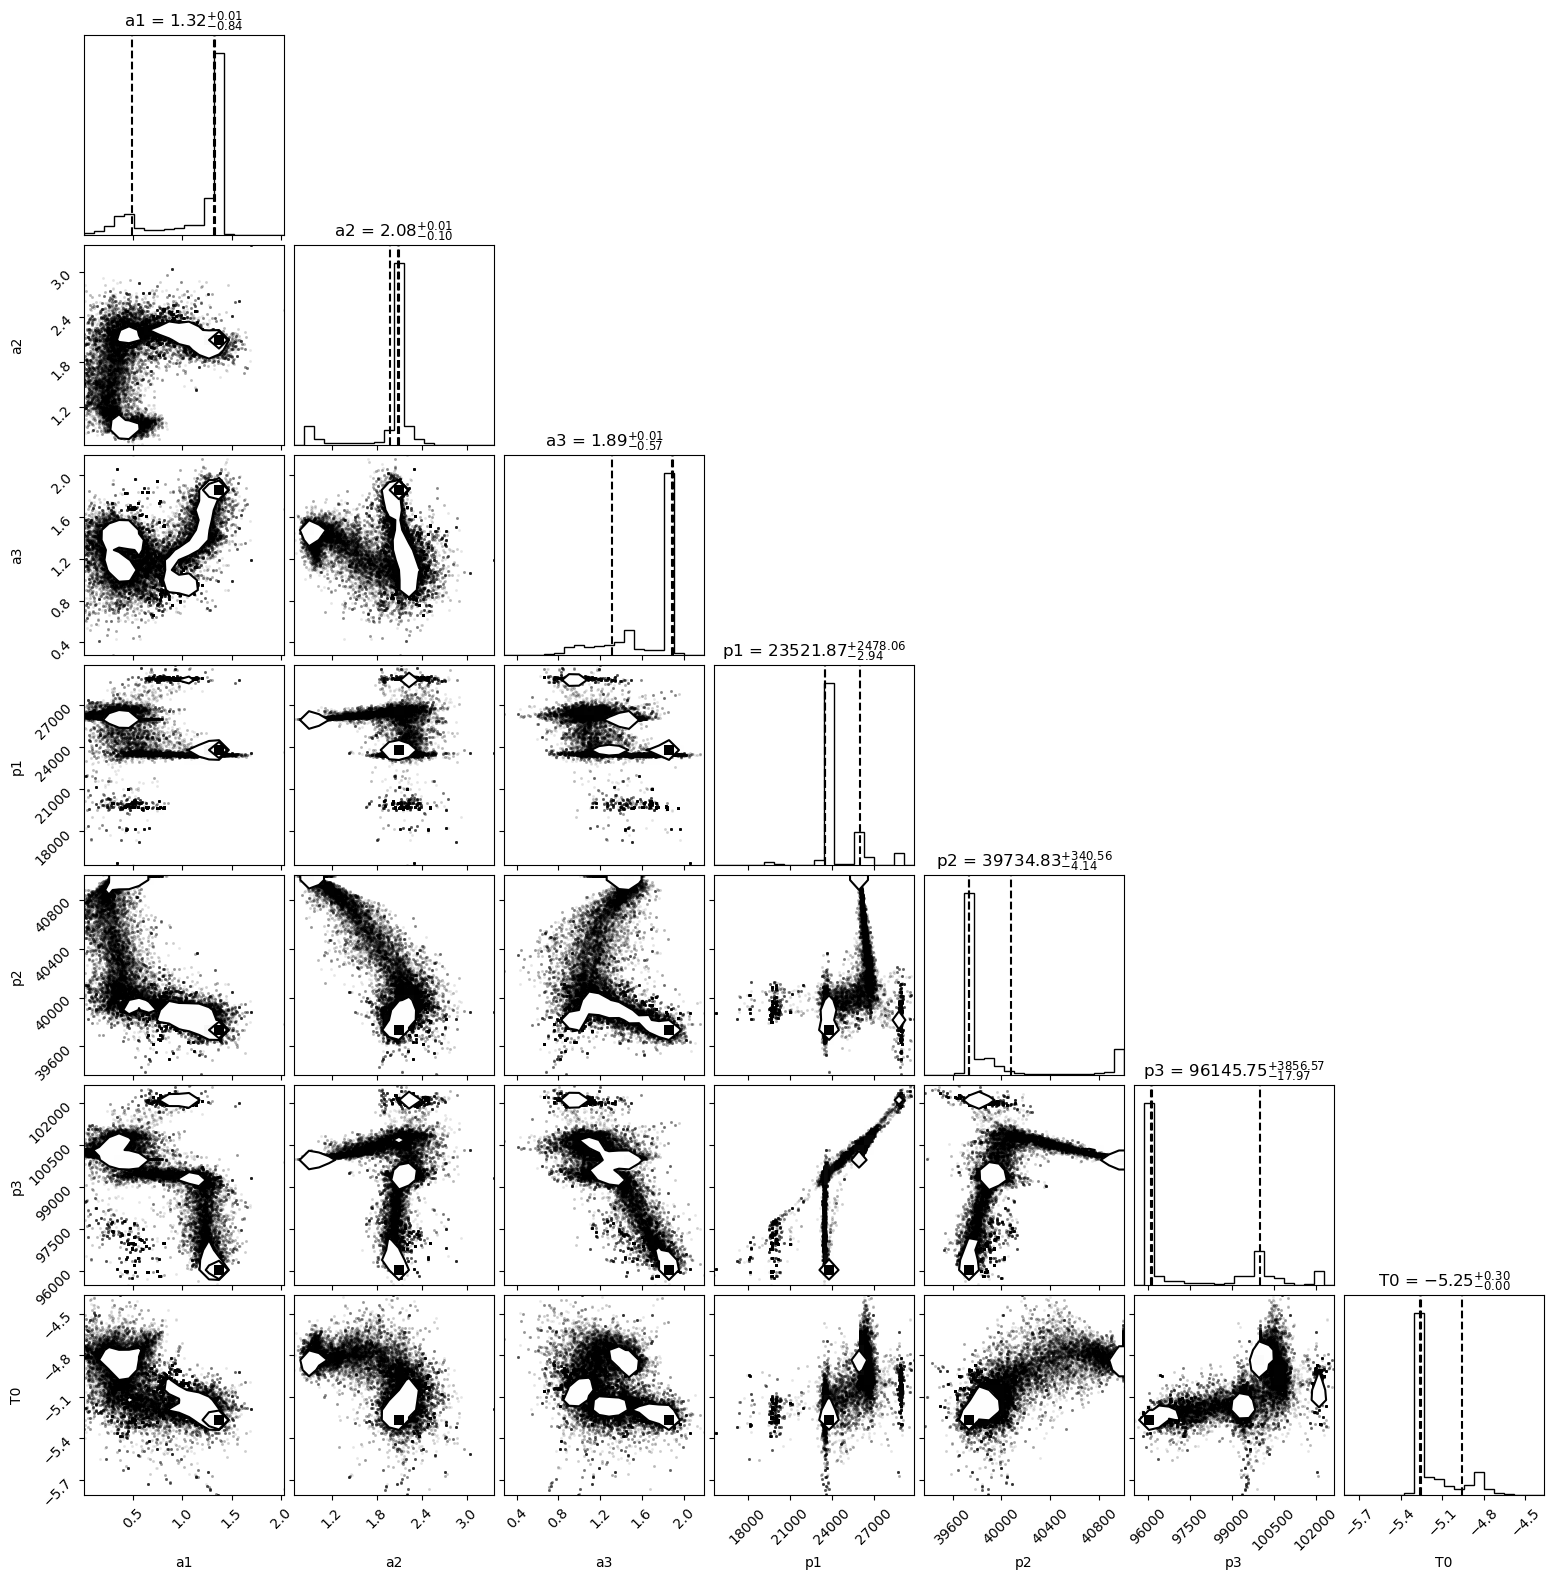

In [55]:
labels = ['a1','a2','a3','p1','p2','p3','T0']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

We see the favored values for each parameter, a useful set of constraints. 